# Prototypical Generative Model (PGM) training

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model_color.ipynb"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.3"
# Don't turn on deterministic ops unless in need of pain
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=false"

import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp

import flax
flax.config.update('flax_use_orbax_checkpointing', True)
from flax.training import checkpoints

import ciclo
import wandb 

from clu import parameter_overview
from clu import deterministic_data

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["savefig.facecolor"] = "white"

from src.transformations import transform_image
from experiments.configs.pgm_mnist_color import get_config
from src.utils.input import get_data
from src.models.transformation_inference_model import TransformationInferenceNet, create_transformation_inference_state, make_transformation_inference_train_and_eval
from src.utils.proto_plots import plot_proto_model_training_metrics
from src.models.transformation_generative_model import TransformationGenerativeNet, make_transformation_generative_train_and_eval, create_transformation_generative_state
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.training import custom_wandb_logger


/home/sp2058/miniconda3/envs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sp2058/miniconda3/envs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
I0000 00:00:1703215569.306480 1153143 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
HUE = 0.6
config = get_config(f"{HUE}")

In [3]:
print((3 * config.model.generative.num_bins + 1) * len(config.model.generative.bounds), config.model.generative.conditioner.hidden_dims[-1])
# Note, we probably want the first number to be smaller than the second number. Haven't tested this yet.

26 256


In [4]:
run = wandb.init(
    project="invariance_icml2024",
    # entity="invariance-learners",
    entity = "shreyaspadhy",
    config=config.to_dict(),
    mode="online",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

wandb: Currently logged in as: shreyaspadhy. Use `wandb login --relogin` to force relogin


In [5]:
rng = random.PRNGKey(config.seed)
data_rng, proto_init_rng, gen_init_rng, proto_state_rng, gen_state_rng = random.split(rng, 5)

## Get data

In [6]:
jax.local_device_count()

1

In [7]:
train_ds, val_ds, _ = get_data(config, data_rng)

INFO:absl:Load dataset info from /home/sp2058/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/sp2058/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /home/sp2058/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ToRgb(color=0, key='image', key_result=None):
{'image': 'uint8[28, 28, 3]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomSaturation(min_factor=0.6, max_factor=0.9, key='image', key_result=None, rng_key='rng'):
{'image': 'uint8[28, 28, 3]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomHue(min_delta=0.0, max_delta=0.6, key='image', k

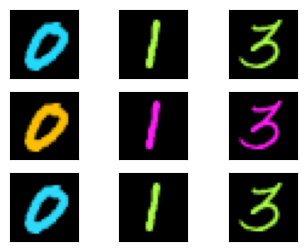

(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0
(28, 28, 3) (28, 28, 3) (28, 28, 3)
-1.0 1.0 -1.0 1.0 -1.0 1.0


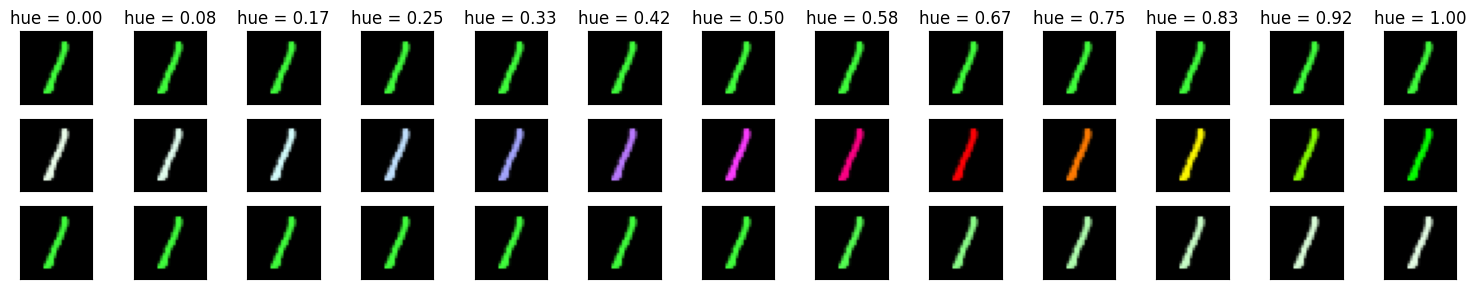

In [8]:
from src.transformations.transforms import HueTransform, HueSaturationTransform
import tensorflow as tf
from src.transformations.color import _rgb_to_hsv

trial_iter = deterministic_data.start_input_pipeline(train_ds)
trial_batch = next(trial_iter)

fig, axs = plt.subplots(3, 3, figsize=(4, 3))

for i, (ax, ax2, ax3) in enumerate(zip(axs[0], axs[1], axs[2])):
    xi = trial_batch['image'][0][i]
    
    # rgb_tuple = tuple(jax.tree_map(jnp.squeeze, jnp.split(xi, 3, axis=-1)))

    # # # Convert to HSV.
    # hsv_tuple = _rgb_to_hsv(*rgb_tuple)
    # print(xi.min(), xi.max(), hsv_tuple[0])
    
    # new_xi = tf.image.adjust_hue(xi, 0.4).numpy()
    
    # rgb_tuple = tuple(jax.tree_map(jnp.squeeze, jnp.split(new_xi, 3, axis=-1)))

    # # # Convert to HSV.
    # hsv_tuple = _rgb_to_hsv(*rgb_tuple)
    # print(new_xi.min(), new_xi.max(), hsv_tuple[0])
    
    # new_xi = (new_xi - 127.5) / 127.5
    # rgb_tuple = tuple(jax.tree_map(jnp.squeeze, jnp.split(new_xi, 3, axis=-1)))

    # # # Convert to HSV.
    # hsv_tuple = _rgb_to_hsv(*rgb_tuple)
    # print(new_xi.min(), new_xi.max(), hsv_tuple[0])
     
    # print(new_xi.min(), new_xi.max())

    transform = HueSaturationTransform(jnp.array((0.6, 0.2)))
    transformed_xi = transform.apply(xi)
    inv_xi = transform.inverse().apply(transformed_xi)

    ax.imshow(rescale_for_imshow(xi))
    # ax2.imshow(rescale_for_imshow(new_xi))
    ax2.imshow(rescale_for_imshow(transformed_xi))
    ax3.imshow(rescale_for_imshow(inv_xi))
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    # break

plt.show()

# break


x = trial_batch['image'][0][14]

n_transforms = 13

fig, axs = plt.subplots(3, n_transforms, figsize=(15, 3))

# etas = jnp.linspace(-jnp.pi, jnp.pi, n_transforms)
etas = jnp.linspace(jnp.array((0., -2.301)), jnp.array((1., 2.301)), n_transforms)

for ax, ax2, ax3, eta in zip(axs[0], axs[1], axs[2], etas):

    # eta_arr = jnp.array((eta, eta / (2*jnp.pi) + 0.5))
    # eta = jnp.expand_dims(eta, axis=0)
    transform = HueSaturationTransform(eta)
    transformed_x = transform.apply(x)

    inv_transformed_x = transform.inverse().apply(transformed_x)
    
    print(x.shape, transformed_x.shape, inv_transformed_x.shape)
    print(x.min(), x.max(), transformed_x.min(), transformed_x.max(), inv_transformed_x.min(), inv_transformed_x.max())


    ax.imshow(rescale_for_imshow(x))
    ax2.imshow(rescale_for_imshow(transformed_x))
    ax3.imshow(rescale_for_imshow(inv_transformed_x))
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.set_xticks([])
    ax3.set_yticks([])

    ax.set_title(f'hue = {eta[0]:.2f}')


plt.tight_layout()

plt.show()


# TransformationInference Network (Prototype inference)

## Setup TrainState and NN

In [9]:
proto_model = TransformationInferenceNet(**config.model.inference.to_dict())

variables = proto_model.init({'params': proto_init_rng, 'sample': proto_init_rng}, jnp.empty((28, 28, 3)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+--------------------------+--------------+-----------+-----------+--------+
| Name                     | Shape        | Size      | Mean      | Std    |
+--------------------------+--------------+-----------+-----------+--------+
| params/Dense_0/bias      | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_0/kernel    | (2352, 1024) | 2,408,448 | -9.25e-07 | 0.0206 |
| params/Dense_1/bias      | (512,)       | 512       | 0.0       | 0.0    |
| params/Dense_1/kernel    | (1024, 512)  | 524,288   | -4.74e-05 | 0.0313 |
| params/Dense_2/bias      | (256,)       | 256       | 0.0       | 0.0    |
| params/Dense_2/kernel    | (512, 256)   | 131,072   | -0.000144 | 0.0443 |
| params/Dense_3/bias      | (128,)       | 128       | 0.0       | 0.0    |
| params/Dense_3/kernel    | (256, 128)   | 32,768    | 6.18e-05  | 0.0625 |
| params/Dense_4/bias      | (2,)         | 2         | 0.0       | 0.0    |
| params/Dense_4/kernel    | (128, 2)     | 256       | 0.0      

In [10]:
params = flax.core.freeze(variables["params"])

proto_state = create_transformation_inference_state(params, proto_state_rng, config)

train_step, eval_step = make_transformation_inference_train_and_eval(config, proto_model)

INFO:absl:A polynomial schedule was set with a non-positive `transition_steps` value; this results in a constant schedule with value `init_value`.
INFO:absl:A polynomial schedule was set with a non-positive `transition_steps` value; this results in a constant schedule with value `init_value`.


In [11]:
total_steps = config.inf_steps
proto_final_state, history, _ = ciclo.train_loop(
    proto_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(total_steps * config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=total_steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=total_steps + 1,
)

10000/10000 [==============================] - 231s 23ms/step - invertibility_loss: 1.5377e-14 - loss: 0.0088 - x_mse: 0.0088 - η_recon_loss: 0.2061 - invertibility_loss_test: 1.5761e-14 - loss_test: 0.0090 - x_mse_test: 0.0090 - η_recon_loss_test: 0.2058 - label_paired_image_mse_test: 0.5252 5:38 - invertibility_loss: 8.7503e-15 - loss: 0.0101 - x_mse: 0.0101 - η_recon_loss: 0.2215 - invertibility_loss_test: 3.6179e-14 - loss_test: 0.0135 - x_mse_test: 0.0135 - η_recon_loss_test: 0.2261 - label_paired_image_mse_test: 0.52 - ETA: 5:38 - invertibility_loss: 8.6657e-15 - loss: 0.0100 - x_mse: 0.0100 - η_recon_loss: 0.2209 - invertibility_loss_test: 3.6179e-14 - loss_test: 0.0135 - x_mse_test: 0.0135 - η_recon_loss_test: 0.2261 - label_paired_image_mse_test: 0.52 - ETA: 5:37 - invertibility_loss: 8.6777e-15 - loss: 0.0100 - x_mse: 0.0100 - η_recon_loss: 0.2209 - invertibility_ - ETA: 1:14 - invertibility_loss: 1.4285e-14 - loss: 0.0096 - x_mse: 0.0096 - η_recon_loss: 0.2091 - invertibilit

In [12]:
run.finish()

augment_bounds_mult,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
blur_sigma,██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm,▅▄▄▅▃▆▄▅▇▄▅█▅▄▄▆▄▇▂▄▂▆▃▄▂▂▄▃▂▂▃▄▂▂▁▁▂▂▁▁
lr_inf,▄▄▆▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
lr_σ,▃▄▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/invertibility_loss,█▂▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▁▁▁▁▁▃▂▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
train/x_mse,█▄▁▁▁▁▁▃▂▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
train/η_recon_loss,█▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
valid/invertibility_loss,▁▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/label_paired_image_mse,█▂▃▁▂▃▆▂▂▃▃▂▁▂▃▃▂▃▁▃▂▂▃▃▂▂▃▃▃▃▂▂▂▃▂▂▄▂▃▃


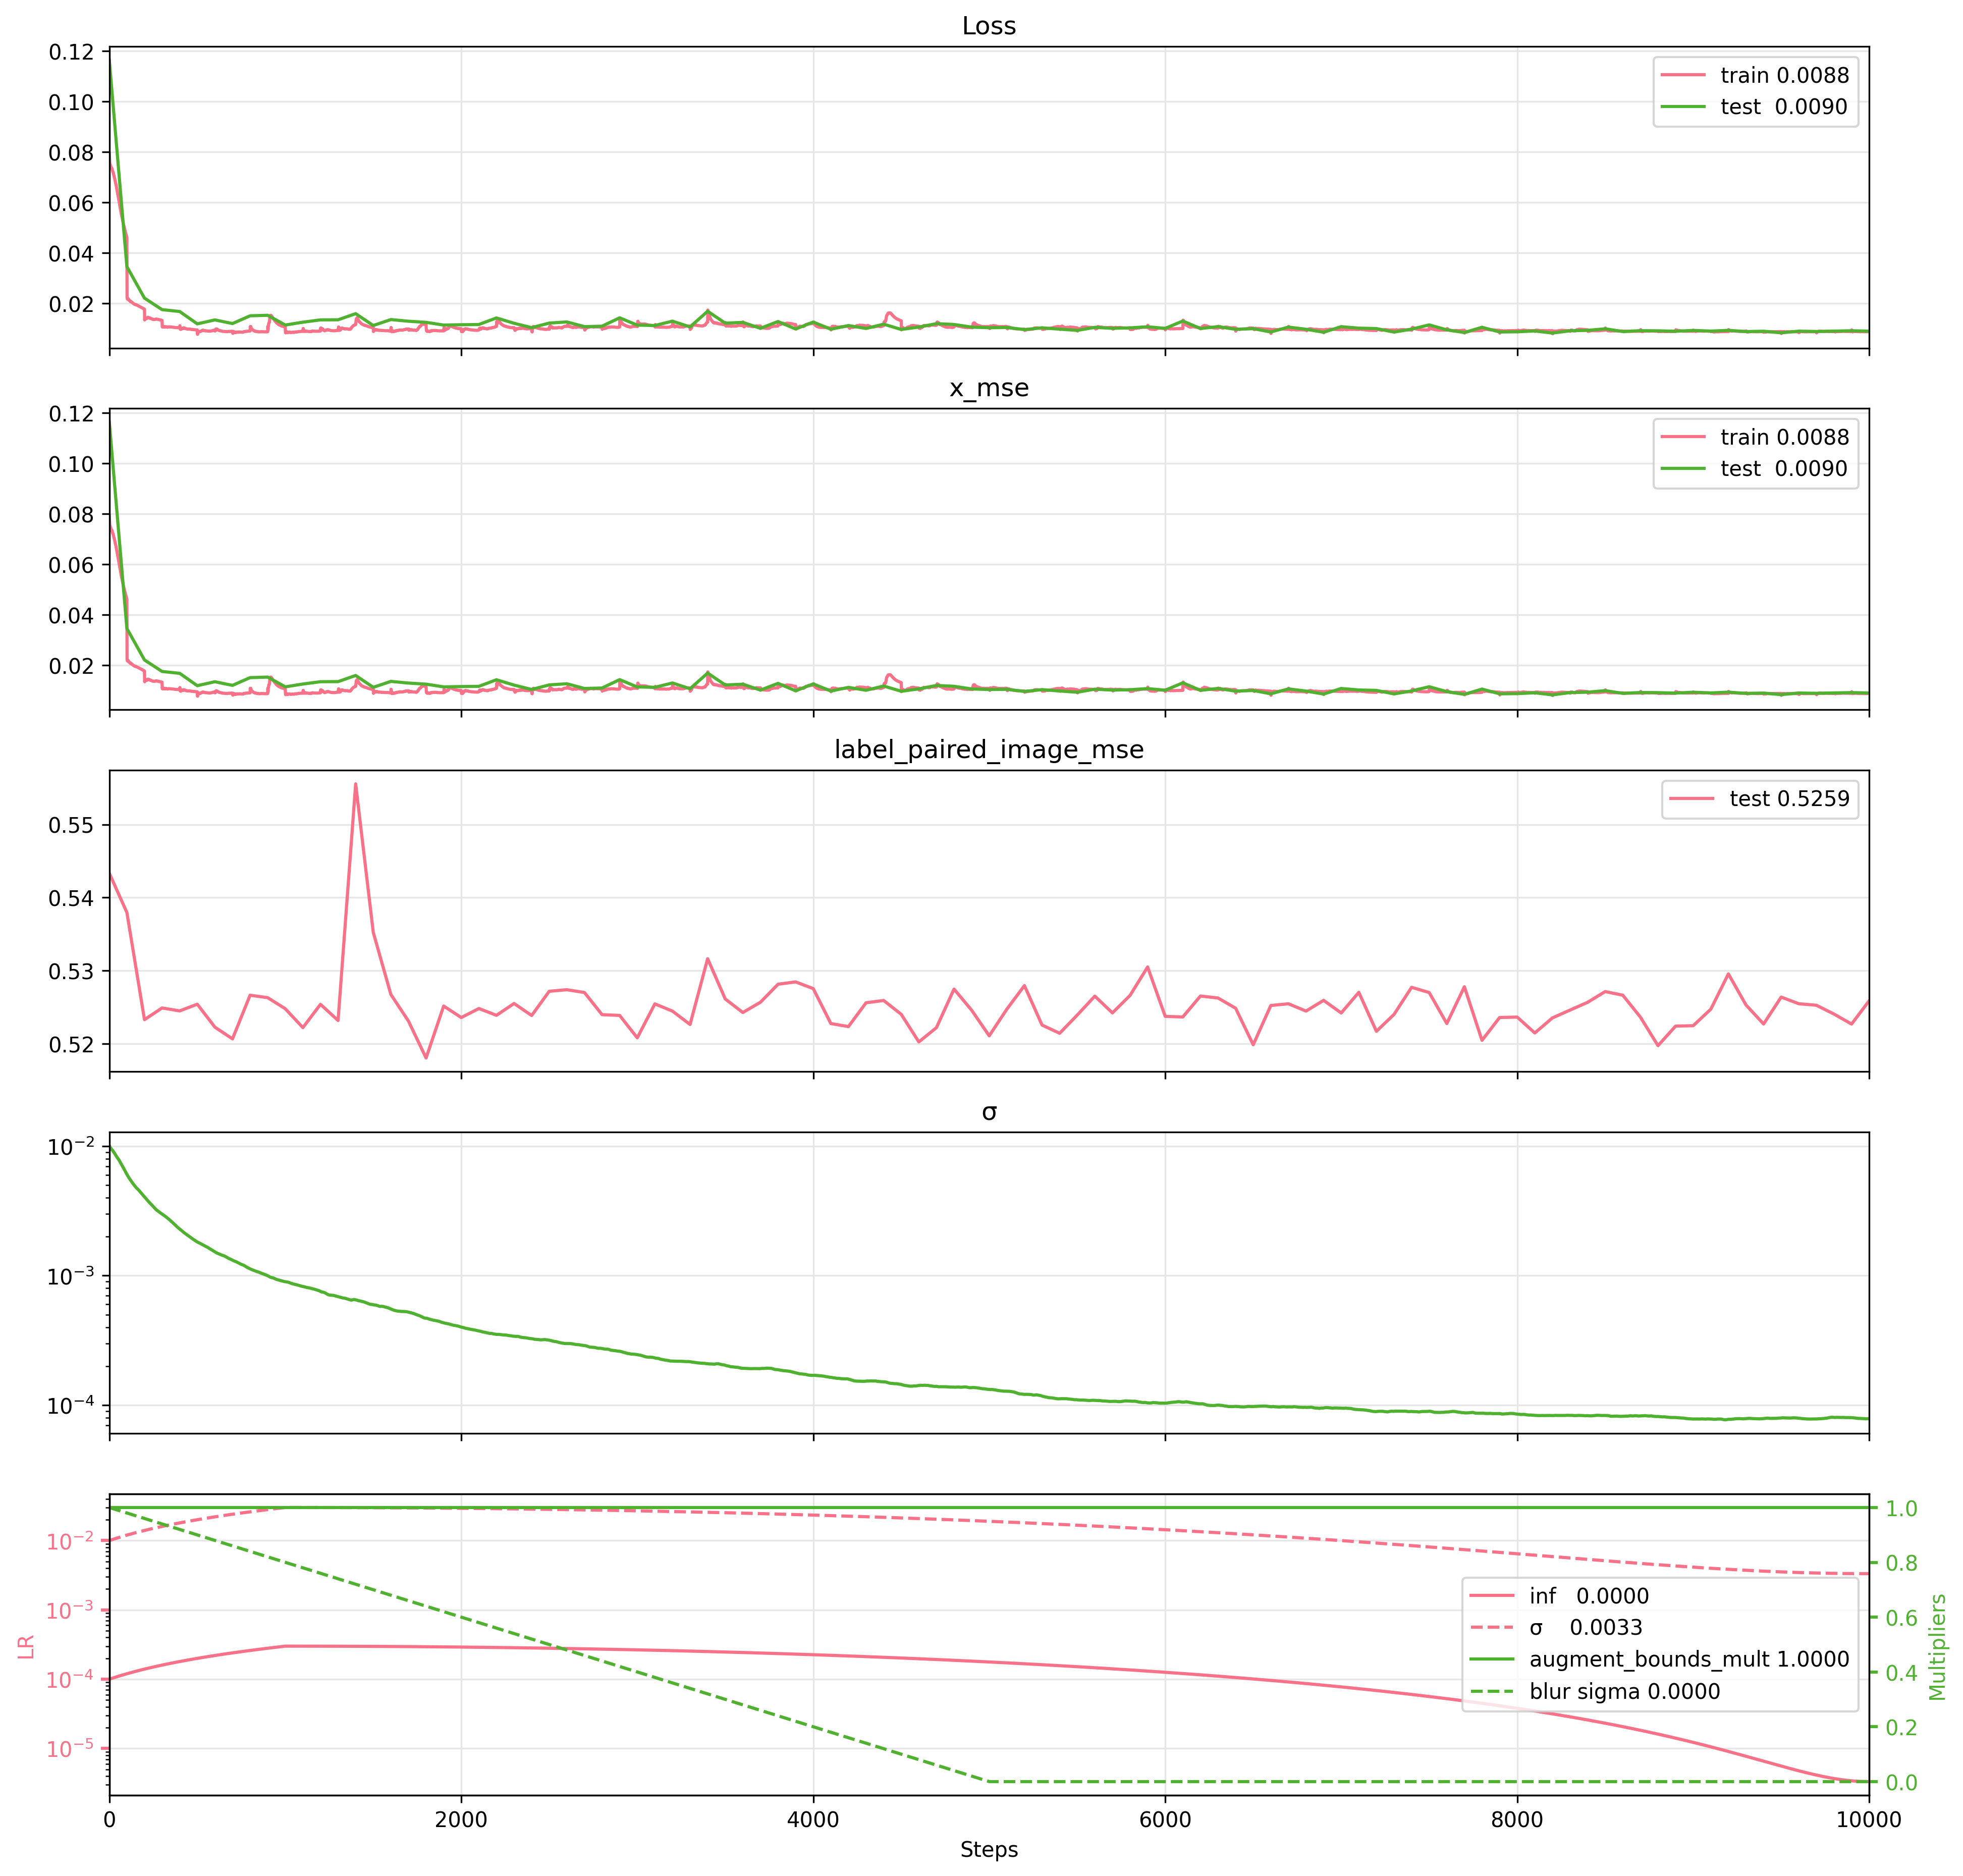

In [13]:
fig = plot_proto_model_training_metrics(history)

In [14]:
jax.nn.softplus(proto_final_state.params['σ_']).mean()

Array(7.85248e-05, dtype=float32)

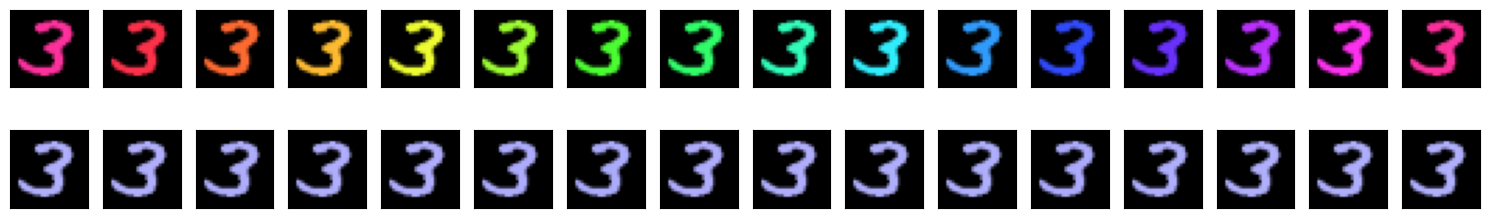

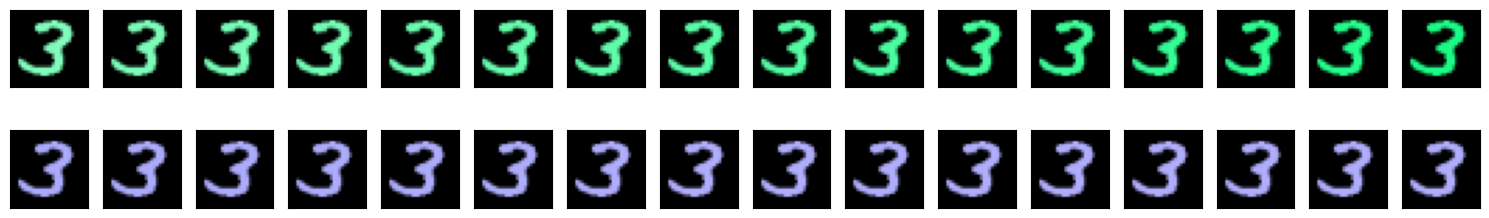

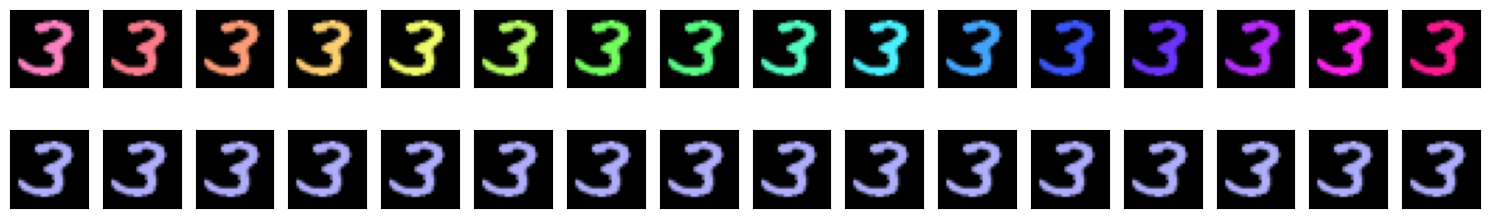

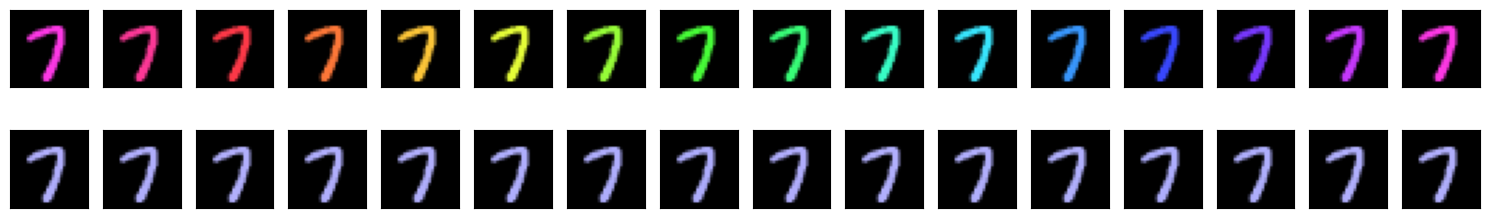

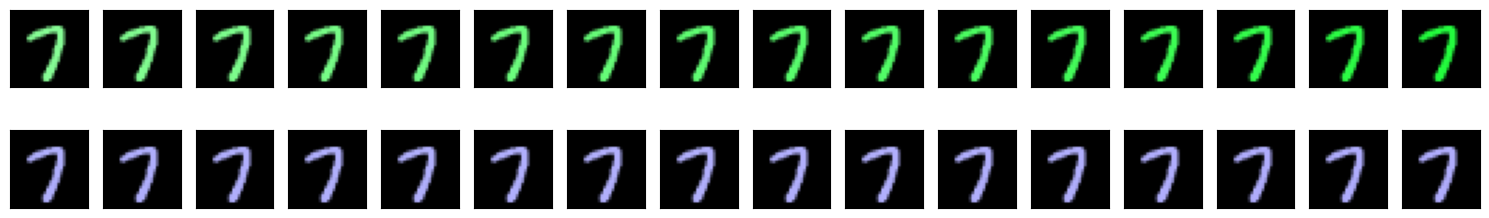

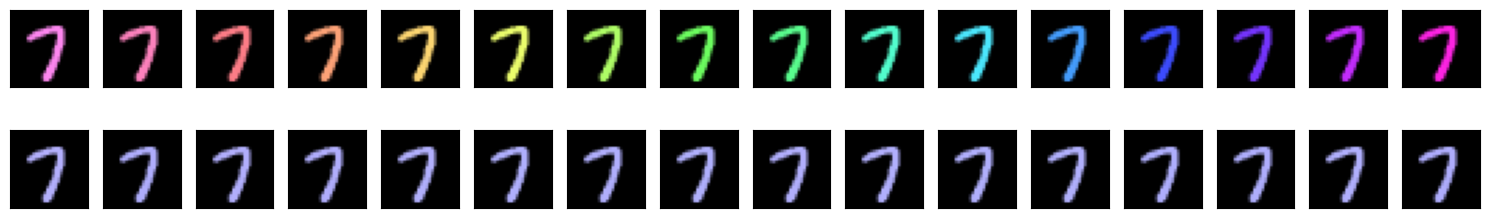

In [15]:
from src.transformations.color import color_transform_image

val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

@jax.jit
def get_prototype(x):
    p_η = proto_model.apply({"params": proto_final_state.params}, x, train=False)
    η = p_η.sample(seed=rng)
    
    transform = proto_model.transform(η).inverse()
    # affine_matrix = gen_affine_matrix_no_shear(η)
    # affine_matrix_inv = jnp.linalg.inv(affine_matrix)
    xhat = transform.apply(x)
    # xhat = transform_image_with_affine_matrix(x, affine_matrix_inv, order=config.interpolation_order)
    return xhat, η

# bounds_1 = (0.5, 0.51, 0.51)
# bounds_2 = (0.5, 0.1, 0.51)
# offset = (0.5, 0., 0.)

bounds_1 = (0.5, 0.51)
bounds_2 = (0.5, 0.1)
offset = (0.5, 0.)

for x_ in [
    val_batch['image'][0][14],
    val_batch['image'][0][12],
]:
    for mask in [
        jnp.array([1, 0]),
        jnp.array([0, 1]),
        jnp.array([1, 1]),
        # jnp.array([0, 1, 0, 0, 0]),
        # jnp.array([1, 1, 0, 0, 0]),
        # # jnp.array([0, 0, 0, 1, 1]),
        # jnp.array([1, 1, 1, 1, 1])
    ]:

        transformed_xs = jax.vmap(color_transform_image, in_axes=(None, 0, None))(
            x_, jnp.linspace(-jnp.array(bounds_1) * mask, jnp.array(bounds_2) * mask, 16),
            "hue_sat"
        )

        xhats, ηs = jax.vmap(get_prototype)(transformed_xs)

        fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

        for ax, x in zip(axs[0], list(transformed_xs)):
            ax.imshow(rescale_for_imshow(x), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        for ax, xhat in zip(axs[1], list(xhats)):
            ax.imshow(rescale_for_imshow(xhat), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

# Generative Network

## Define the prototype function

In [16]:
def prototype_function(x, rng):
    η = proto_model.apply({"params": proto_final_state.params}, x, train=False).sample(seed=rng)
    return η

In [17]:
gen_model = TransformationGenerativeNet(**config.model.generative.to_dict())

variables = gen_model.init({'params': gen_init_rng, 'sample': gen_init_rng}, 
                           jnp.empty((28, 28, 3)), 
                           η=jnp.empty((2,)), 
                           train=False)
parameter_overview.log_parameter_overview(variables)

INFO:absl:
+------------------------------------------------+--------------+-----------+-----------+--------+
| Name                                           | Shape        | Size      | Mean      | Std    |
+------------------------------------------------+--------------+-----------+-----------+--------+
| params/ConditionedConditioner_0/Dense_0/bias   | (256,)       | 256       | 0.0       | 0.0    |
| params/ConditionedConditioner_0/Dense_0/kernel | (258, 256)   | 66,048    | 0.000401  | 0.0622 |
| params/ConditionedConditioner_0/Dense_1/bias   | (256,)       | 256       | 0.0       | 0.0    |
| params/ConditionedConditioner_0/Dense_1/kernel | (256, 256)   | 65,536    | 0.000244  | 0.0627 |
| params/ConditionedConditioner_0/Dense_2/bias   | (26,)        | 26        | 0.0       | 0.0    |
| params/ConditionedConditioner_0/Dense_2/kernel | (256, 26)    | 6,656     | 0.0       | 0.0    |
| params/ConditionedConditioner_1/Dense_0/bias   | (256,)       | 256       | 0.0       | 0.0    |

In [18]:
gen_params = flax.core.freeze(variables["params"])

gen_state = create_transformation_generative_state(gen_params, gen_state_rng, config)

train_step, eval_step = make_transformation_generative_train_and_eval(config, gen_model, prototype_function=prototype_function)

In [19]:
run = wandb.init(
    project="iclr2024experiments",
    # entity="invariance-learners",
    entity="shreyaspadhy",
    config=config.to_dict(),
    mode="online",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

In [20]:
gen_final_state, history, _ = ciclo.train_loop(
    gen_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(config.gen_steps * config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=config.gen_steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=config.gen_steps + 1,
)

10000/10000 [==============================] - 211s 21ms/step - log_p_η_x_hat: 4.5883 - loss: -4.5304 - mae: 0.0582 - log_p_η_x_hat_test: 4.5969 - loss_test: -4.5372 - mae_test: 0.0597


In [21]:
run.finish()

grad_norm,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_gen,▃▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mae_loss_mult,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/log_p_η_x_hat,▁▂▅▅▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████████
train/loss,█▇▄▄▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,██▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/log_p_η_x_hat,▁███████████████████████████████████████
valid/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/mae,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm,0.39982
lr_gen,0.0


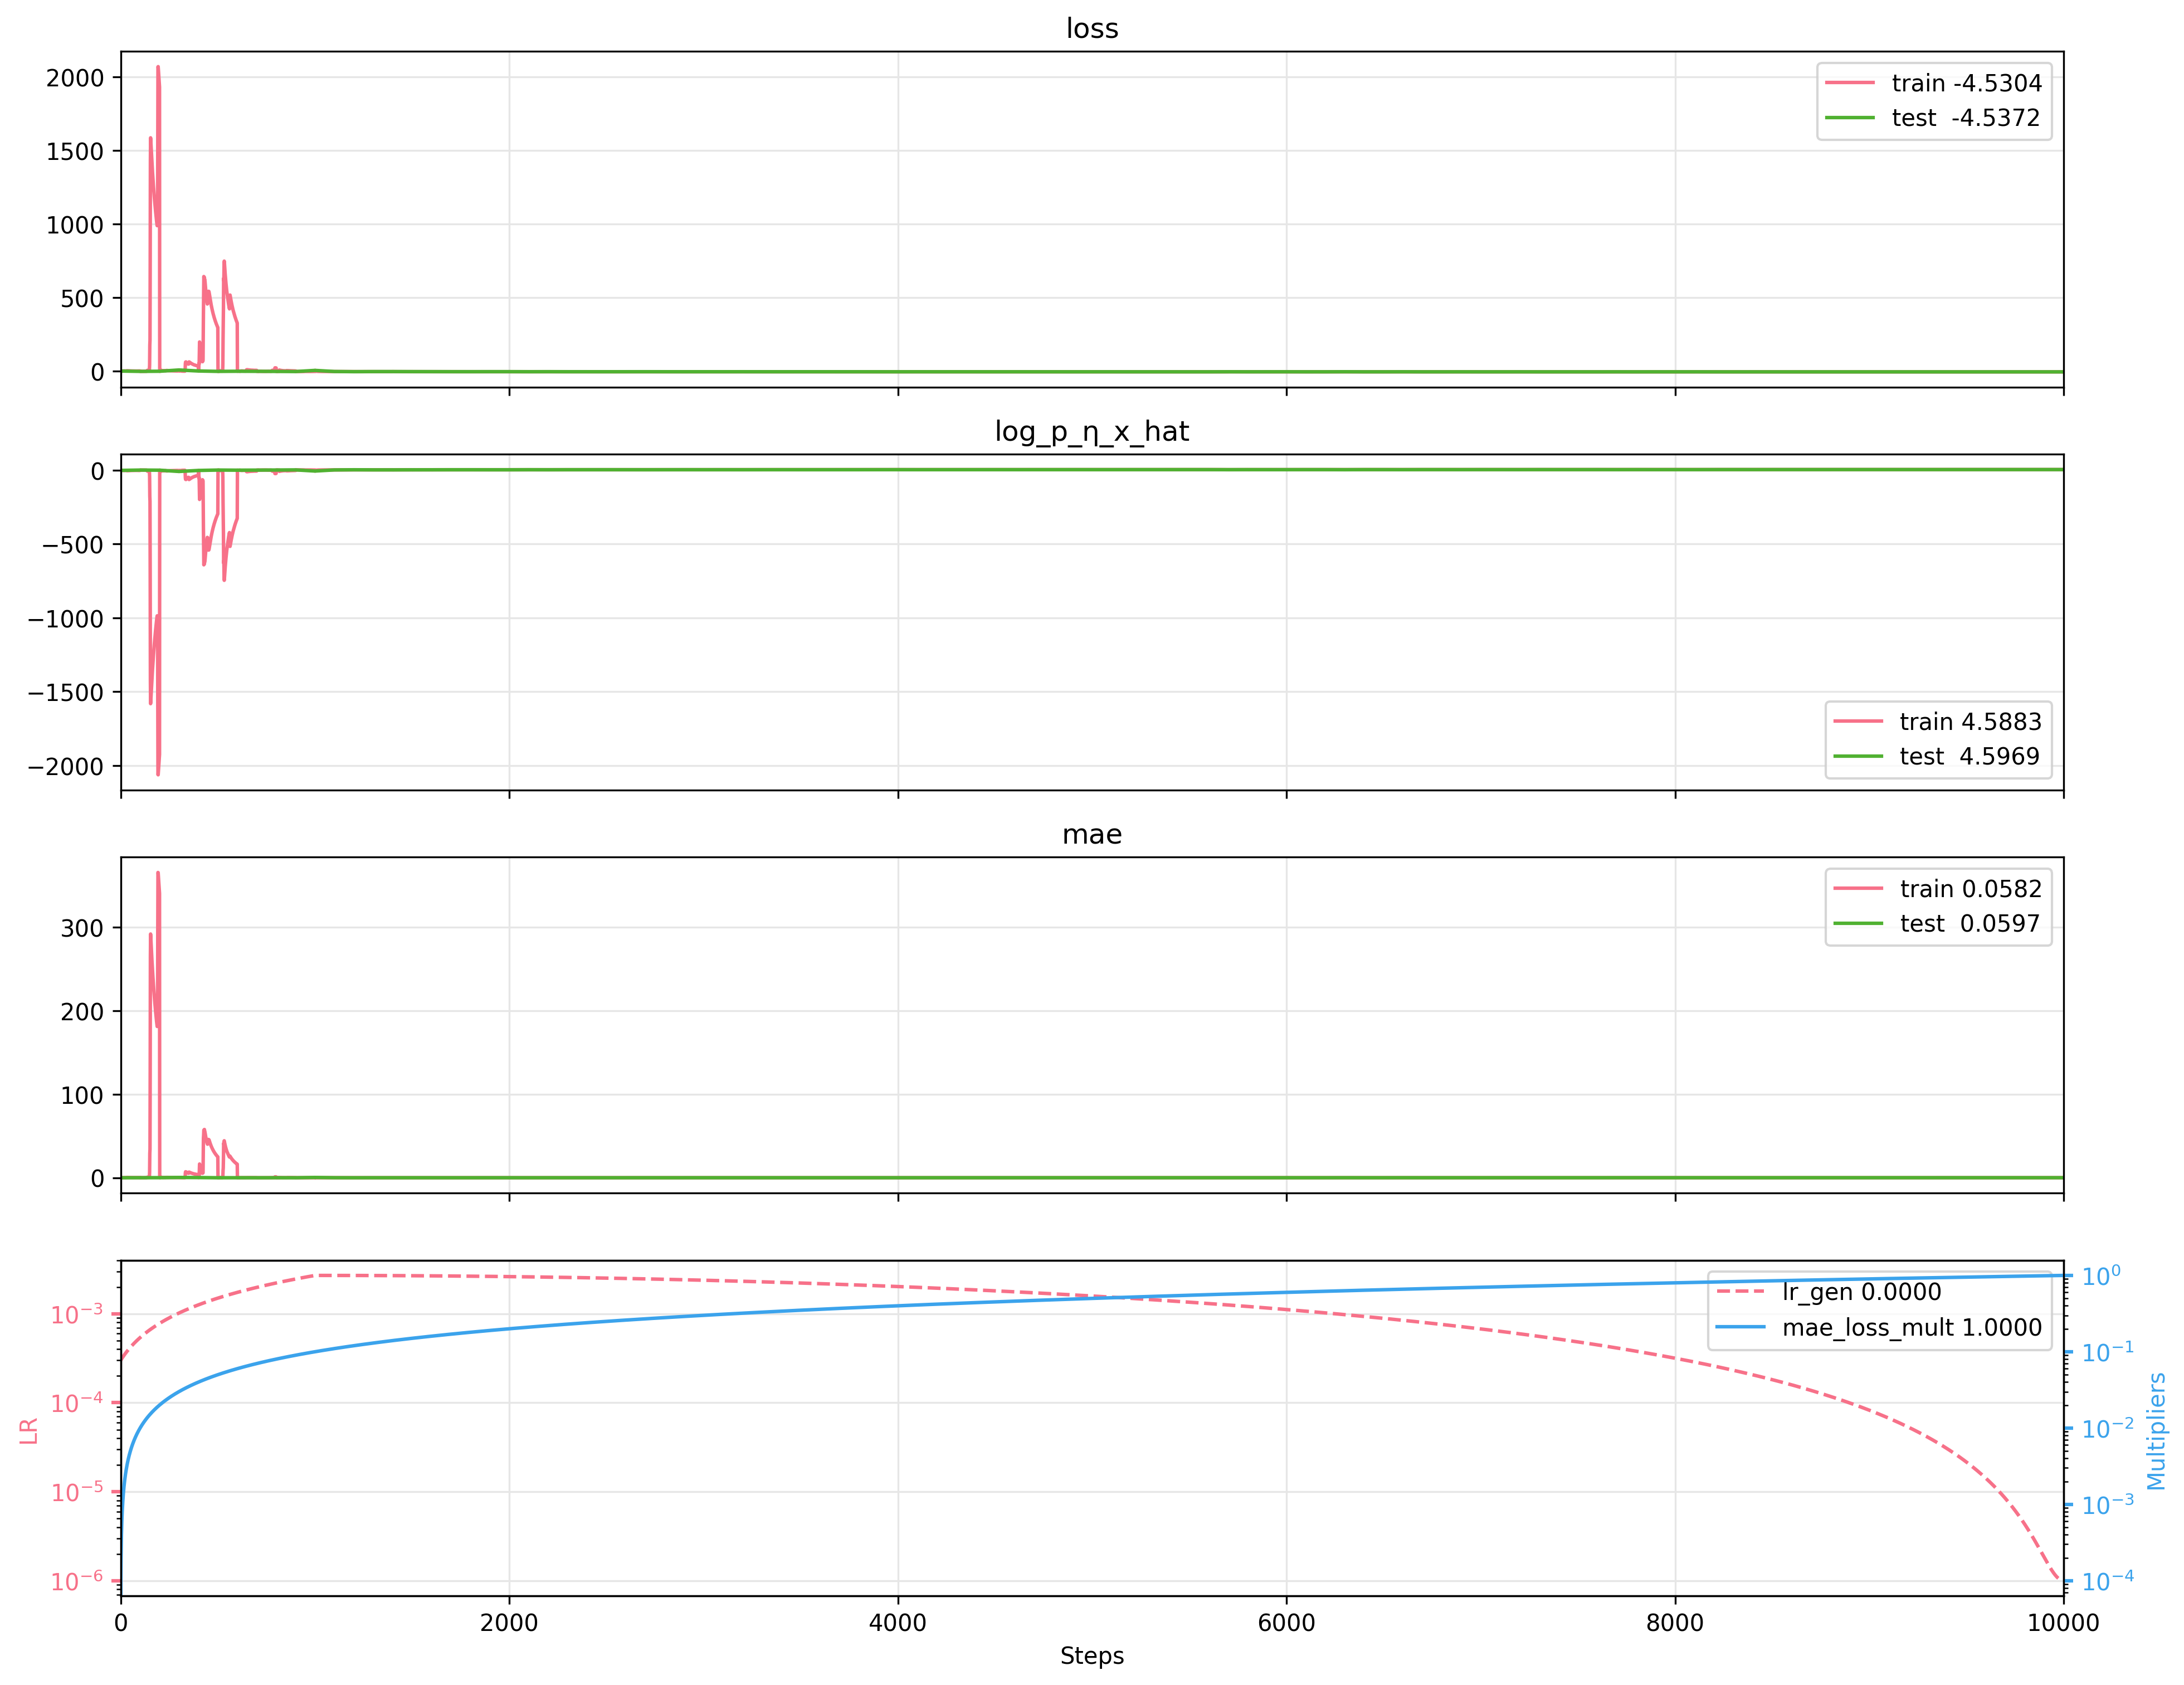

In [21]:
colors = sns.color_palette("husl", 3)

# plot the training history
steps, loss, log_p_η_x_hat, mae, lr_gen,  = history.collect(
    "steps",
    "loss",
    "log_p_η_x_hat",
    "mae",
    "lr_gen"
)
mae_loss_mult = history.collect("mae_loss_mult")
steps_test, loss_test, log_p_η_x_hat_test, mae_test = history.collect(
    "steps", "loss_test", "log_p_η_x_hat_test", "mae_test"
)

n_plots = 4
fig, axs = plt.subplots(
    n_plots, 1, figsize=(15, n_plots * 3.0), dpi=300, sharex=True
)

for train_metric, test_metric, metric_name, ax in zip(
    [loss, log_p_η_x_hat, mae],
    [loss_test, log_p_η_x_hat_test, mae_test],
    ["loss", "log_p_η_x_hat", "mae"],
    axs,
):
    ax.plot(steps, train_metric, label=f"train {train_metric[-1]:.4f}", color=colors[0])
    ax.plot(steps_test, test_metric, label=f"test  {test_metric[-1]:.4f}", color=colors[1])
    ax.legend()
    ax.set_title(metric_name)

# Schedule axis:
lr_ax = axs[-1]
multiplier_ax = lr_ax.twinx()
# par2 = host.twinx()

p1, = lr_ax.plot(steps, lr_gen, "--", label=f"lr_gen {lr_gen[-1]:.4f}", color=colors[0])
p2, = multiplier_ax.plot(
    steps,
    mae_loss_mult,
    label=f"mae_loss_mult {mae_loss_mult[-1]:.4f}",
    color=colors[2]
)
lines = [p1, p2]
lr_ax.legend(lines, [l.get_label() for l in lines])

lr_ax.set_yscale("log")
multiplier_ax.set_yscale("log")
# par2.set_yscale("log")

lr_ax.set_ylabel(f"LR")
# par1.set_ylabel("σ LR")
multiplier_ax.set_ylabel("Multipliers")

lr_ax.yaxis.label.set_color(p1.get_color())
multiplier_ax.yaxis.label.set_color(p2.get_color())
# par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
lr_ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
multiplier_ax.tick_params(axis='y', colors=p2.get_color(), **tkw)
# par2.tick_params(axis='y', colors=p3.get_color(), **tkw)

axs[-1].set_xlim(min(steps), max(steps))
axs[-1].set_xlabel("Steps")

for ax in axs:
    ax.grid(color=(0.9, 0.9, 0.9))

plt.show()

In [22]:
# best_state = checkpoints.restore_checkpoint(ckpt_dir='checkpoint', target=state)
# best_state.step
gen_final_state.params
gen_model

TransformationGenerativeNet(
    # attributes
    hidden_dims = (1024, 512, 256)
    num_flows = 2
    num_bins = 4
    bounds = (0.5, 2.301)
    offset = (0.5, 0.0)
    conditioner = {'hidden_dims': (256, 256)}
    ε = 1e-06
    squash_to_bounds = False
    transform = HueSaturationTransform
)

In [38]:
from scipy.stats import gaussian_kde


# function to plot the histograms of p(η|x_hat) in each dimmension
def plot_hists(x, n=10_000):
    # q_H_x = q_H_X.apply(q_H_X_vars, x)
    # ηs_q = canon_functini(seed=random.PRNGKey(0), sample_shape=(n))
    # η = ηs_q[jnp.argmax(log_probs)]
    # TODO: is the argmaxing here necessary? Why not do it in the canon_function?
    η = prototype_function(x, rng)
    transform = gen_model.transform(η).inverse()
    xhat = transform.apply(x, order=config.interpolation_order)

    p_H_x_hat, _ = gen_model.apply({"params": gen_final_state.params}, xhat)
    
    ηs_p = p_H_x_hat.sample(seed=random.PRNGKey(0), sample_shape=(10_000,))

    transform_param_dim = η.shape[0]
    fig, axs = plt.subplots(1, transform_param_dim + 2, figsize=(3*(transform_param_dim+2), 3))

    axs[0].imshow(rescale_for_imshow(x), cmap='gray')
    axs[1].imshow(rescale_for_imshow(xhat), cmap='gray')
    
    
    image = (x + 1.0) / 2.0
    rgb_tuple = tuple(jax.tree_map(jnp.squeeze, jnp.split(image, 3, axis=-1)))
    h,s,v = _rgb_to_hsv(*rgb_tuple)
    
    axs[0].set_title(f'HSV = ({h.max():.2f}, {s.max():.2f}, {v.max():.2f})')
    
    image = (xhat + 1.0) / 2.0
    rgb_tuple = tuple(jax.tree_map(jnp.squeeze, jnp.split(image, 3, axis=-1)))
    h,s,v = _rgb_to_hsv(*rgb_tuple)
    peak_sat = s.max()
    axs[1].set_title(f'HSV = ({h.max():.2f}, {s.max():.2f}, {v.max():.2f})')
    
    

    for i, ax in enumerate(axs[2:]):
        # x = np.linspace(ηs_p[:, i].min(), ηs_p[:, i].max(), 1000)
        
        if i in  [1]:
            x = np.linspace(jnp.exp(config.augment_bounds[i] - 1e-5 + config.augment_offset[i]), 
                            jnp.exp(-config.augment_bounds[i] + 1e-5 + config.augment_offset[i]), 1000)
        else:
            x = np.linspace(config.augment_bounds[i] - 1e-5 + config.augment_offset[i], 
                            -config.augment_bounds[i] + 1e-5 + config.augment_offset[i], 1000)
        
        if i in [1]:
            # x = np.exp(x)
            ηs_p_ = np.exp(ηs_p[:, i])
            # ηs_q_ = np.exp(ηs_q[:, i])
            η_ = np.exp(η[i])
        else:
            ηs_p_ = ηs_p[:, i]
            # ηs_q_ = ηs_q[:, i]
            η_ = η[i]


        # plot p(η|x_hat)
        # ax.hist(ηs_p[:, i], bins=100, density=True, alpha=0.5, color="C0")
        ax.hist(ηs_p_, bins=100, density=True, alpha=0.5, color="C0")
        # kde = gaussian_kde(ηs_p[:, i])
        kde = gaussian_kde(ηs_p_)
        ax.plot(x, kde(x), color="C0")
        
        if i == 1:
            ax2 = ax.twiny()
            min_x = ηs_p_.min()
            max_x = ηs_p_.max()
            ax2.set_xlim(min_x, max_x)
            # ax2.set_xticks([0.6 / peak_sat, 0.7 / peak_sat, 0.8 / peak_sat, 0.9 / peak_sat, 1.0 / peak_sat])
            # ax2.set_xticklabels([0.6, 0.7, 0.8, 0.9, 1.0])
            ax2.set_xticks([0.6 / peak_sat, 0.8 / peak_sat, 1.0 / peak_sat])
            ax2.set_xticklabels([0.6, 0.8, 1.0])
            ax2.set_xlabel(r"$s_{\text{prototype}} \times \exp(\eta)$")
        
        if i == 0:
            ax2 = ax.twiny()
            ax2.set_xlim(-config.augment_bounds[i] + config.augment_offset[i],  
                         config.augment_bounds[i] + config.augment_offset[i])
            # min_x = ηs_p_.min()
            # max_x = ηs_p_.max()
            # ax2.set_xlim(min_x, max_x)
            # ax2.set_xticks([0.6 / peak_sat, 0.7 / peak_sat, 0.8 / peak_sat, 0.9 / peak_sat, 1.0 / peak_sat])
            # ax2.set_xticklabels([0.6, 0.7, 0.8, 0.9, 1.0])
            ax2.set_xticks([0., 0.5, 1.])
            ax2.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
            ax2.set_xlabel(r"$h$")

        # make a axvline to plot η, make the line dashed
        # ax.axvline(η[i], color="C1", linestyle="--")
        ax.axvline(η_, color="C1", linestyle="--")
        # make a twin axis to plot q(η|x)
        # ax2 = ax.twinx()
        # ax2.hist(ηs_q[:, i], bins=100, density=True, alpha=0.5, color="C1")
        # kde = gaussian_kde(ηs_q[:, i])
        # ax2.plot(x, kde(x), color="C1")
        
        titles = {
            1: "Saturation",
            0: "Hue",
            2: "Value"}
        xlabels = {
            1: r"$\exp(\eta)$",
            0: r"$\eta$",
            2: r"$\exp(\eta)$"}
        ax.set_title(titles[i], fontsize=16)
        ax.set_xlabel(xlabels[i], fontsize=12)
        if i in [1]:
            min_x = ηs_p_.min()
            max_x = ηs_p_.max()
            ax.set_xlim(min_x, max_x)
            # ax.set_xlim(np.exp(-config.model.bounds[i] + config.model.offset[i]), np.exp(config.model.bounds[i] + config.model.offset[i]))
        else:
            ax.set_xlim(-config.augment_bounds[i] + config.augment_offset[i],  
                        config.augment_bounds[i] + config.augment_offset[i])


        # ax.set_title(f"dim {i}")
        # print(x.min(), x.max())
        # ax.set_xlim(x.min(), x.max())

    plt.tight_layout()
    plt.show()

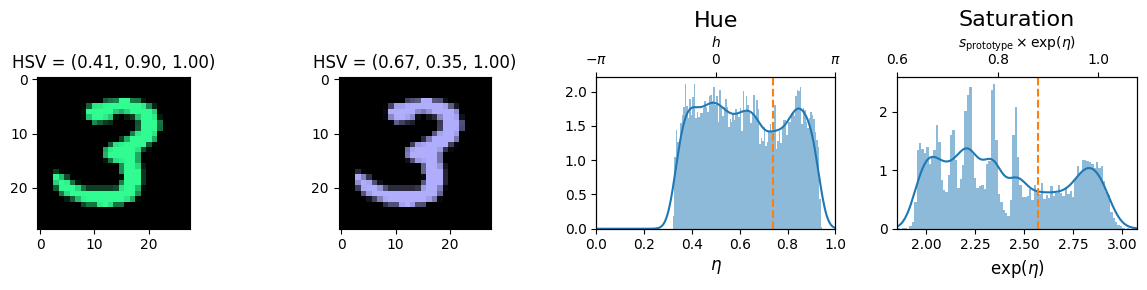

In [39]:
plot_hists(val_batch['image'][0][14], n=4_000)
# plot_hists(val_batch['image'][0][1], n=4_000)
# plot_hists(val_batch['image'][0][4], n=1_000)
# plot_hists(val_batch['image'][0][9], n=1_000)

-0.04335886240005493 0.630768895149231


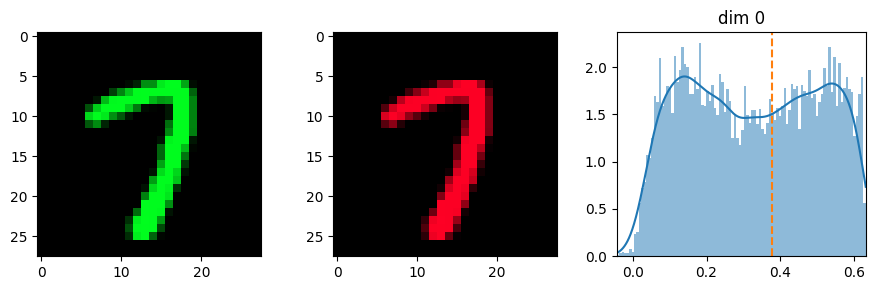

-0.043361663818359375 0.6307795643806458


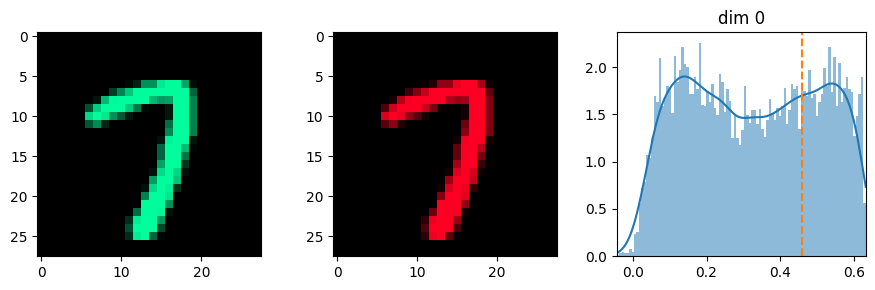

-0.043370962142944336 0.6307821273803711


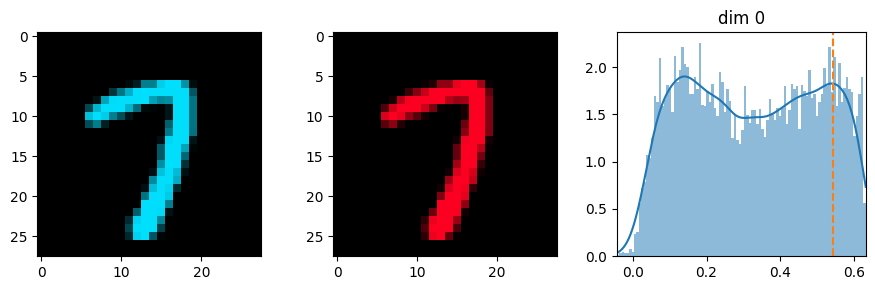

-0.04336589574813843 0.6307709217071533


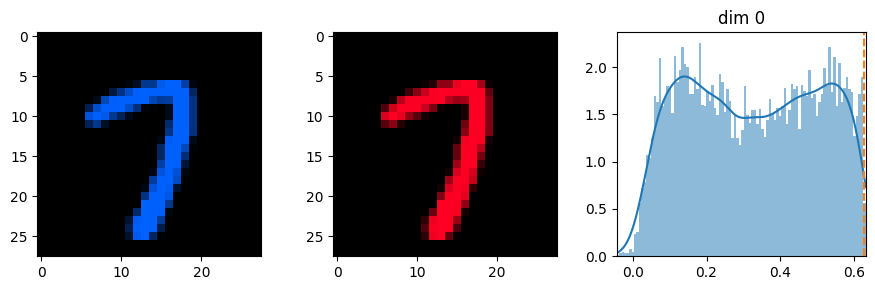

-0.04337793588638306 0.6307843327522278


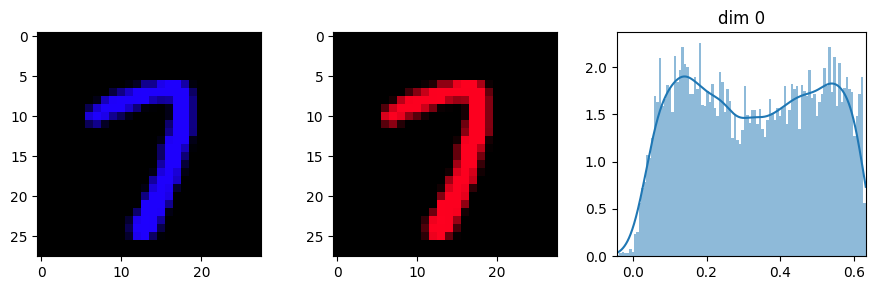

-0.04337012767791748 0.6307718753814697


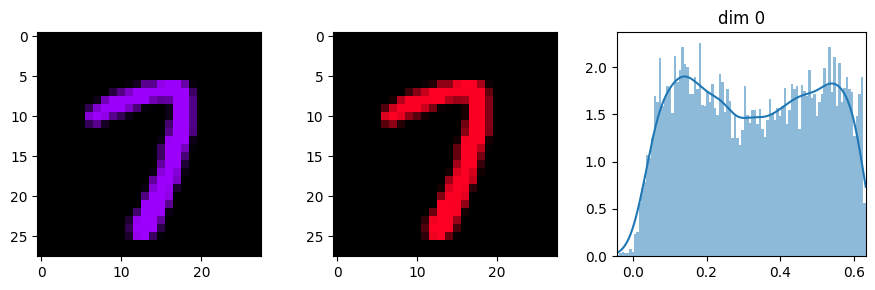

-0.04338228702545166 0.6307855248451233


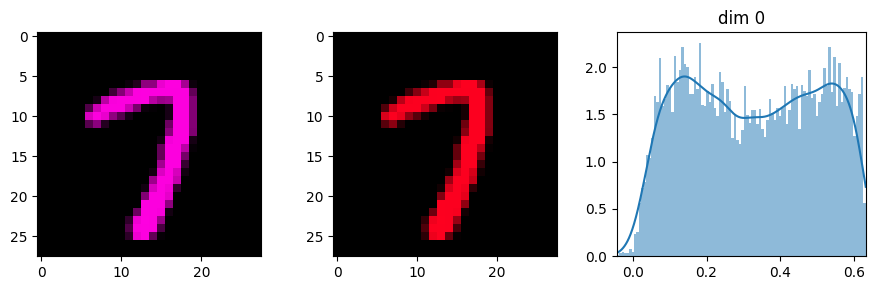

-0.04335319995880127 0.6307671666145325


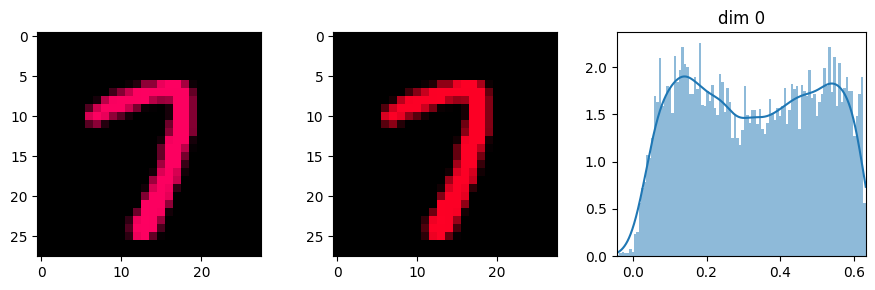

-0.043353378772735596 0.6307671666145325


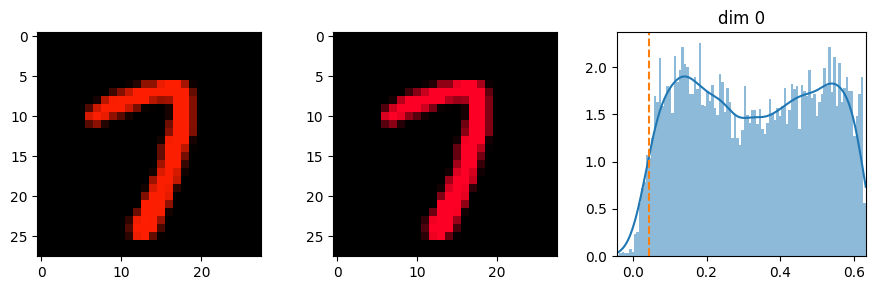

-0.04331749677658081 0.6307572722434998


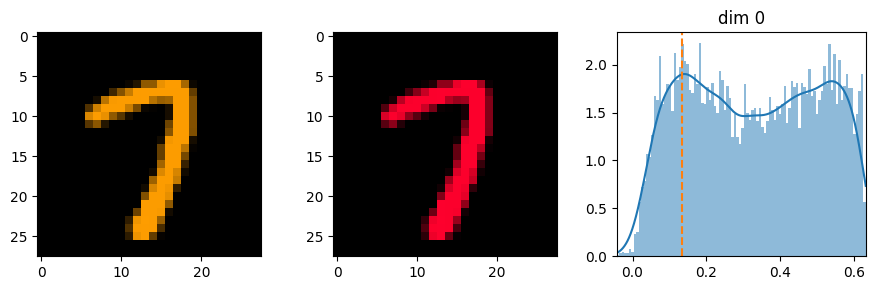

-0.04334443807601929 0.6307647228240967


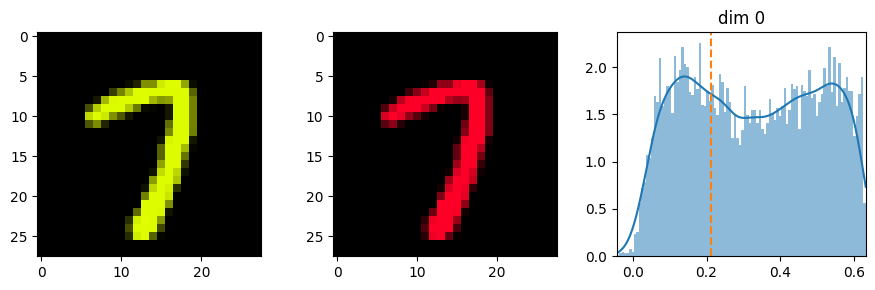

-0.04335331916809082 0.6307671666145325


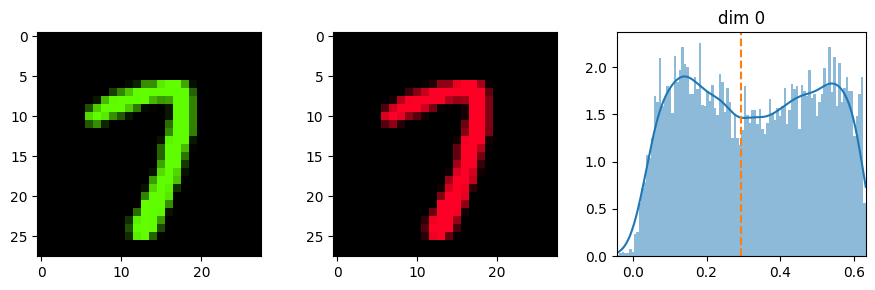

-0.04335886240005493 0.630768895149231


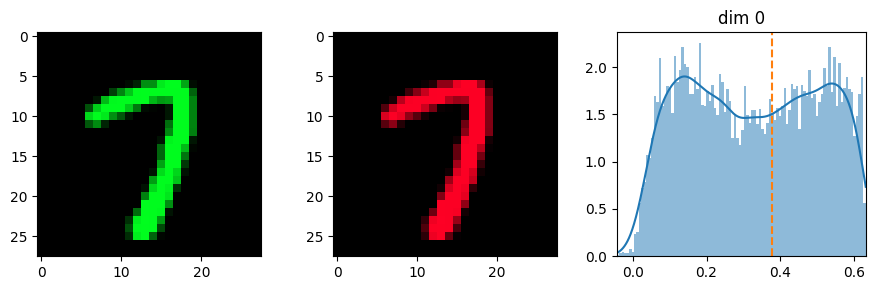

In [26]:
bounds = jnp.linspace(-config.augment_bounds[0] + config.augment_offset[0],
                      config.augment_bounds[0] + config.augment_offset[0],
                      13)

transformed_xs = jax.vmap(color_transform_image, in_axes=(None, 0))(
    x_,
    bounds[..., None],
)

for x in transformed_xs:
    plot_hists(x, n=1_000)

[]

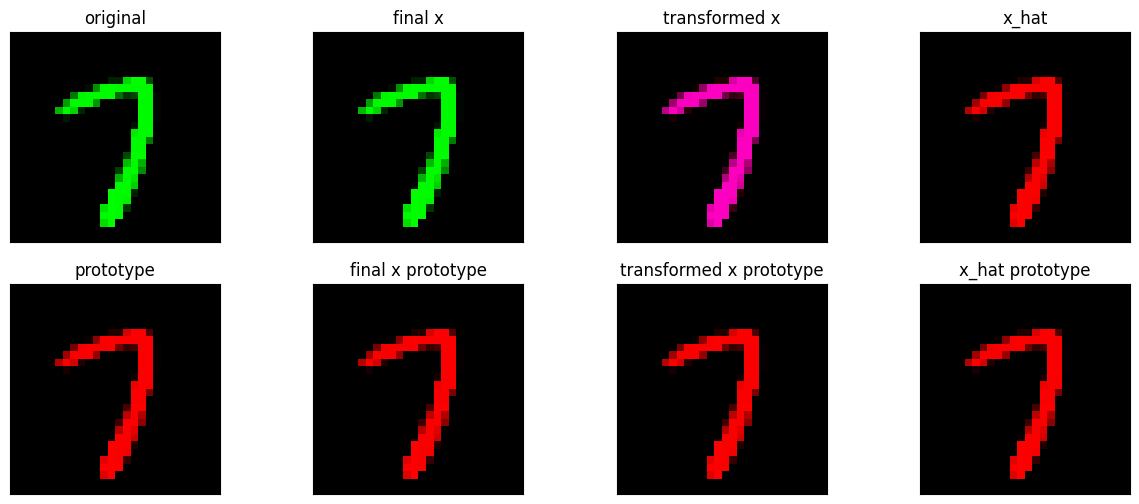

In [27]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = color_transform_image(x, jnp.array(config.augment_bounds))
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
